# SparkDev AI Hurricane Trajectory Prediction

In this project, we'll be using neural networks to predict the trajectory paths of hurricanes in South Florida. We will be using the Hurricane Database dataset from Unisys Weather. Here we will preprocess the data, then train a recurrent neural network on some of the samples. At the end, we'll get to see our neural network's hurricane trajectory path predictions.

### Get and Analyze the Data

[Here's the link containing the entire dataset.](http://weather.unisys.com/hurricane/atlantic/) So far, we're using only the years 2000 to 2009 and is saved on our repo as '2000-2009-data.csv'. We have to get an idea of the hurricanes' behavior to properly create a model for our neural network. 

In [ ]:
!pip install pandas==0.20.3

     |████████████████████████████████| 24.5MB 173kB/s 
ERROR: xarray 0.15.1 has requirement pandas>=0.25, but you'll have pandas 0.20.3 which is incompatible.
ERROR: seaborn 0.10.0 has requirement pandas>=0.22.0, but you'll have pandas 0.20.3 which is incompatible.
ERROR: plotnine 0.6.0 has requirement pandas>=0.25.0, but you'll have pandas 0.20.3 which is incompatible.
ERROR: pandas-datareader 0.8.1 has requirement pandas>=0.21, but you'll have pandas 0.20.3 which is incompatible.
ERROR: mizani 0.6.0 has requirement pandas>=0.25.0, but you'll have pandas 0.20.3 which is incompatible.
ERROR: google-colab 1.0.0 has requirement pandas~=1.0.0; python_version >= "3.0", but you'll have pandas 0.20.3 which is incompatible.
ERROR: featuretools 0.4.1 has requirement pandas>=0.23.0, but you'll have pandas 0.20.3 which is incompatible.
ERROR: fbprophet 0.6 has requirement pandas>=0.23.4, but you'll have pandas 0.20.3 which is incompatible.
  Found existing installation: pandas 1.0.3
    Uninsta

In [ ]:
# ALL THE IMPORTS NECESSARY
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

from geopy.distance import great_circle as vc
import math as Math

# from mpl_toolkits.basemap import Basemap
# import matplotlib.cm as cm

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
import math, time

from keras.models import model_from_json

Using TensorFlow backend.


In [ ]:
data = pd.read_csv('/content/drive/My Drive/Machine Learning/Hurricane/Code/1920-2012-data.csv', index_col=None, names=['Year', 'Month', 'Day', 'Hour', 'HurricaneNum', 'Name', 'Lat', 'Long', 'WindSpeed', 'Pressure', 'NullCol'])

# Create a unique key for all of the hurricane
data['unique-key'] = data['Name'] + '-' + data['Year'].map(str) + '-' + data['HurricaneNum'].map(str)

# Delete the columns of information that we are not using so far
data.drop(['Name', 'HurricaneNum', 'Year', 'NullCol'], axis = 1, inplace = True)

# Preview the first 5 rows of data
data.head()

,Month,Day,Hour,Lat,Long,WindSpeed,Pressure,unique-key
0,6,7,18,21,-93.0,25.0,0,NOTNAMED-2000-1
1,6,8,0,20.9,-92.8,25.0,0,NOTNAMED-2000-1
2,6,8,6,20.7,-93.1,25.0,0,NOTNAMED-2000-1
3,6,8,12,20.8,-93.5,25.0,0,NOTNAMED-2000-1
4,6,23,0,9.5,-19.8,25.0,0,NOTNAMED-2000-2


In [ ]:
# Remove hurricanes where pressure = 0
data = data[data['Pressure'] != 0]
data.head()

,Month,Day,Hour,Lat,Long,WindSpeed,Pressure,unique-key
16,8,3,18,10.8,-18.0,25.0,1007,ALBERTO-2000-3
17,8,4,0,11.5,-20.1,30.0,1005,ALBERTO-2000-3
18,8,4,6,12,-22.3,35.0,1004,ALBERTO-2000-3
19,8,4,12,12.3,-23.8,35.0,1003,ALBERTO-2000-3
20,8,4,18,12.7,-25.2,40.0,1002,ALBERTO-2000-3


In [ ]:
# Total amount of hurricanes we have in our dataset 
total_hurricane_count = len(pd.unique(data['unique-key']))
print(total_hurricane_count)

790


In [ ]:
# Finding errors in CSV
print(data[data['Lat'].str.contains("NAMED")])

data = data[~data['Lat'].str.contains("NAMED")]

      Month  Day  Hour    Lat  Long  WindSpeed  Pressure   unique-key
5997      8   31    12  NAMED  37.1      -64.3        25  NOT-2011-20
5998      8   31    18  NAMED  37.1      -64.1        25  NOT-2011-20
5999      9    1     0  NAMED  37.3      -63.9        25  NOT-2011-20
6000      9    1     6  NAMED  37.4      -63.7        30  NOT-2011-20
6001      9    1    12  NAMED  37.4      -63.7        40  NOT-2011-20
6002      9    1    18  NAMED  37.4      -63.8        35  NOT-2011-20
6003      9    2     0  NAMED  37.5      -63.8        35  NOT-2011-20
6004      9    2     6  NAMED  37.8      -63.7        40  NOT-2011-20
6005      9    2    12  NAMED  38.0      -62.8        40  NOT-2011-20
6006      9    2    18  NAMED  39.0      -61.8        35  NOT-2011-20
6007      9    3     0  NAMED  40.0      -60.7        30  NOT-2011-20
6008      9    3     6  NAMED  41.0      -59.9        30  NOT-2011-20
6009      9    3    12  NAMED  42.0      -59.2        30  NOT-2011-20
6010      9    3    

In [ ]:
# Total amount of hurricanes we have in our dataset 
total_hurricane_count = len(pd.unique(data['unique-key']))
print(total_hurricane_count)

789


In [ ]:
# Since our keys are strings, we enumerate them to access them as integers 
keys = list(enumerate(pd.unique(data['unique-key'])))

total_hurricane_count = len(pd.unique(data['unique-key']))
print(total_hurricane_count)

y = np.zeros((total_hurricane_count))
for x in range(0,total_hurricane_count):
    y[x] = len(pd.DataFrame(data[data['unique-key'] == keys[x][1]], columns = data.keys()).reset_index(drop = True))
    
# Now contains how many time instances of data (or rows) each hurricane contains 
hurricane_amount = pd.DataFrame(y)

789


In [ ]:
# Print the hurricane key with the amount of data they contain
print ('Top 6 Hurricanes (in terms of data quantity)')
for x in hurricane_amount.nlargest(6, 0).index:
    print (keys[x][1], "-", hurricane_amount.loc[x][0])
    
# Provides statistical information about the DataFrame 
# From here we can see that the shortest hurricane only has 4 rows of information and the largest hurricane has 94 rows
hurricane_amount.describe()

Top 6 Hurricanes (in terms of data quantity)
NADINE-2012-14 - 96.0
IVAN-2004-9 - 94.0
KYLE-2002-12 - 90.0
ALBERTO-2000-3 - 87.0
ARLENE-1987-2 - 81.0
NICHOLAS-2003-19 - 80.0


,0
count,789.000000
mean,20.778200
std,18.740283
min,1.000000
25%,6.000000
50%,15.000000
75%,31.000000
max,96.000000


In [ ]:
cond = (hurricane_amount > 6) & (hurricane_amount < 60)
keys25 = []

for x in cond.index:
    if cond.loc[x][0]:
        keys25.append(keys[x][1])

word2keys = {}
for x in keys:
    word2keys[x[1]] = x[0]
    
data = data[data['unique-key'].isin(keys25)]
keys = list(enumerate(pd.unique(data['unique-key'])))
data.head()

,Month,Day,Hour,Lat,Long,WindSpeed,Pressure,unique-key
116,8,13,18,22.5,-93.5,30.0,1008,BERYL-2000-5
117,8,14,0,22.7,-93.8,30.0,1008,BERYL-2000-5
118,8,14,6,23.1,-94.6,35.0,1007,BERYL-2000-5
119,8,14,12,23.5,-95.4,40.0,1009,BERYL-2000-5
120,8,14,18,23.9,-96.3,45.0,1009,BERYL-2000-5


In [ ]:
# Print the hurricane key with the amount of data they contain
print ('Top 6 Hurricanes (in terms of data quantity)')
for x in hurricane_amount.nlargest(6, 0).index:
    print (keys[x][1], "-", hurricane_amount.loc[x][0])

Top 6 Hurricanes (in terms of data quantity)
FABIAN-1991-9 - 96.0
EMILY-2005-5 - 94.0
DANNY-2003-5 - 90.0
BERYL-2000-5 - 87.0
IRENE-1971-18 - 81.0
HERMINE-2004-8 - 80.0


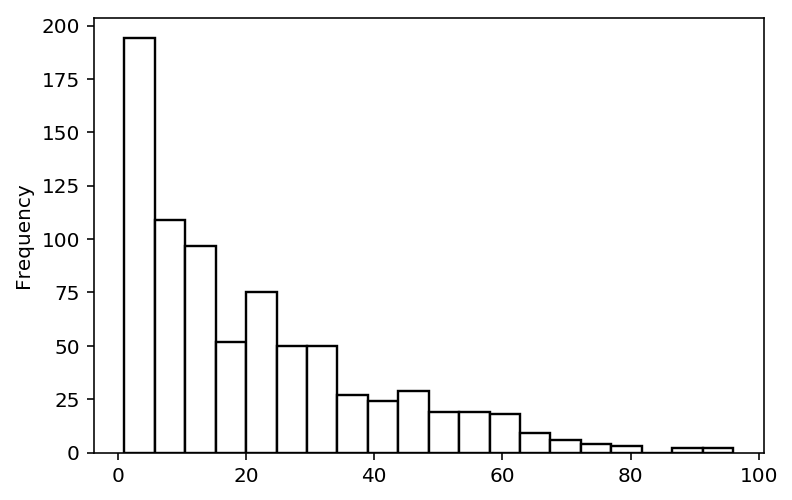

In [ ]:
# Print the distribution of data quantity for all hurricanes
dist = hurricane_amount.plot.hist(bins=20, edgecolor='black', histtype='barstacked', color='white', legend=None, linewidth=1.2)
plt.show()

In [ ]:
data.describe()

,Month,Day,Hour,Long,WindSpeed,Pressure
count,13131.000000,13131.000000,13131.000000,13131.000000,13131.000000,13131.000000
mean,8.724621,15.828269,9.186810,-64.398149,50.883939,993.863834
std,1.375840,8.906905,6.729553,20.182565,25.903755,18.023786
min,1.000000,1.000000,0.000000,-109.300000,10.000000,882.000000
25%,8.000000,8.000000,6.000000,-80.700000,30.000000,987.000000
50%,9.000000,16.000000,12.000000,-65.800000,45.000000,1000.000000
75%,10.000000,24.000000,18.000000,-49.500000,65.000000,1007.000000
max,12.000000,31.000000,23.000000,13.500000,165.000000,1024.000000


In [ ]:
# Since our keys are strings, we enumerate them to access them as integers 
keys = list(enumerate(pd.unique(data['unique-key'])))

total_hurricane_count = len(pd.unique(data['unique-key']))
print(total_hurricane_count)

y = np.zeros((total_hurricane_count))
for x in range(0,total_hurricane_count):
    y[x] = len(pd.DataFrame(data[data['unique-key'] == keys[x][1]], columns = data.keys()).reset_index(drop = True))
    
# Now contains how many time instances of data (or rows) each hurricane contains 
hurricane_amount = pd.DataFrame(y)

539


In [ ]:
# Total amount of data tuples
total_data_count = len(data)
print(total_data_count)

13131


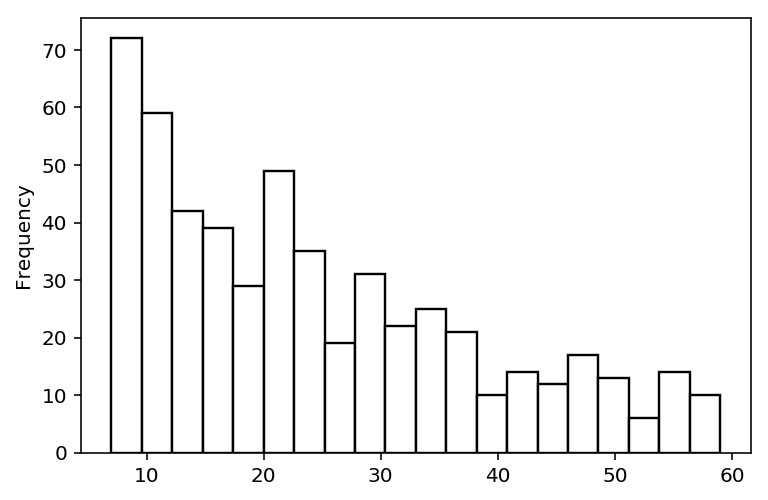

In [ ]:
# Print the distribution of data quantity for all hurricanes
dist = hurricane_amount.plot.hist(bins=20, edgecolor='black', histtype='barstacked', color='white', legend=None, linewidth=1.2)
# plt.savefig('frequency_graph', dpi=600)
plt.show()

In [ ]:
data.to_csv('/content/drive/My Drive/Machine Learning/Hurricane/Code/checkpoint-dataframe.csv') # Save the dataframe to csv for checkpoint